<a href="https://colab.research.google.com/github/mduffy23/Sarcasm-Detection-AIML-Final-Project/blob/main/Sarcasm_Detection_Final_Project_AIML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project - Sarcasm Detection

There is a common experience amoung people of reading a text and not being sure if it is supposed to be sarcastic or not (or even being on the reverse, trying to text and make sure the other person knows you are being sarcastic). It is a bit awkward and difficult to interpret without inflection that one usually uses when saying something sarcastic.

This project aims to generate a model that can predict of a statement is sarcastic or not, purely based on the text used. Capitalization, punctuation, and word choice can all help indicate whether or not the writer of a comment meant to express the statement sarcastically.

- The baseline model if TFID.
- The final model is a fine tuned RoBERTA model.

## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/Final AIML Project - Sarcasm Detection'

Mounted at /content/drive


In [3]:
#!pip install -q transformers datasets accelerate sentencepiece
#!pip install -q torch --index-url https://download.pytorch.org/whl/cu121
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 15.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from datasets import Dataset, ClassLabel, Features
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
import torch
import torch.nn as nn
from datasets import Dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaModel,
    TrainingArguments,
    Trainer,
    default_data_collator
)
from transformers.modeling_outputs import SequenceClassifierOutput
import json
import optuna

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


## Dataset

Dataset comes from https://www.kaggle.com/datasets/danofer/sarcasm. The dataset was downloaded via kaggle hub on my local machine and moved into google drive for easy access. This dataset contains 1,010,826 comments from Reddit, balanced between not sarcastic and sarcastic comments. The sarcasm data was generated by scraping comments containing a sarcasm tag.

I initally planned to use a headline sarcasm dataset, but this was insufficient because the *sarcastic* comments did not relfect the sarcasm used by people in conversation. The idea behind this project is that one could get a text out of no where (or in the midst of chat) and get a reasonable prediction of the text they are reading is sarcastic or not. Reddit was a far better alternative to capture sarcasm that people utilzie.

In [ ]:
sarcasm = pd.read_csv(project_path + '/train-balanced-sarcasm.csv')
print(sarcasm.info())
display(sarcasm.head())
display(pd.DataFrame(sarcasm['label'].value_counts().reset_index().rename(columns={'index': 'label', 'label': 'count'})))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010771 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB
None


,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


,count,count
0,0,505413
1,1,505413


Perfect balance between classes as promised by dataset author!

In [ ]:
display(sarcasm.isna().sum())
sarcasm.dropna(inplace=True)

,0
label,0
comment,55
author,0
subreddit,0
score,0
ups,0
downs,0
date,0
created_utc,0
parent_comment,0


Must drop any null comments.

In [ ]:
sarcasm['subreddit'].value_counts().head(20)

,count
subreddit,
AskReddit,65674
politics,39493
worldnews,26375
leagueoflegends,21034
pcmasterrace,18987
funny,17939
news,16891
pics,16152
todayilearned,14159


- **Bias Potential**

  - There are so many different subreddits that make up this dataset, ranging from video games, sports, politics, and just general discourse. The *AskReddit* subreddit dominates the dataset with 65,674 (over 25,000 more entries than the next largest category).

  - An important consideration is whether a high-volume subreddit like AskReddit should be excluded or treated differently during training. Perhaps any subreddit that accounts for a large amount of the comments could inject bias into the model, causing the model to become overly sensitive to sarcastic patterns that are unique to that community. Moreover, *AskReddit* poses questions that are answered by people, and oftentimes the answers are sarcastic, but one would only know that based on the question at hand. Since this model detects sarcasm from just the comment, sarcastic responses from AskReddit could be content dependent, unbeknownst to the model.
  
  - However, I do **not** think this means AskReddit should be removed. All online comments are produced within a larger context, so the model must be robust to varied contexts and communication styles. Excluding a major portion of real-world sarcastic content might actually hurt performance/ reduce generalizability.  
  
  - Maybe adding a feature for the parent comment would help with the detection of more contextual sarcasm, but there is value catching sarcasm that comes out of the blue. Not using any parent comment for context should help the model understand the essence of sarcasm, rather than how to respond to someone sarcastically. Maybe a sarcasm generation model would be better suited to use a parent comment for a training feature, good for a future porject, but for this model it will not be used.

Taking a fairly large sample of the data and then splitting it into X and y.

In [ ]:
sample_sarcasm, _ = train_test_split(sarcasm, train_size=0.75, random_state=102, stratify=sarcasm['label'])
sample_sarcasm.reset_index(drop=True, inplace=True)
sample_sarcasm.shape

(758078, 10)

In [ ]:
X = sample_sarcasm['comment']
y = sample_sarcasm['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102, stratify=y)

## Text Processing

### Lexical Features

I want the model to learn sarcasm from training on the Reddit comments, but I also want to help it along by identifying common indicators of sarcasm. I created function to add a lexical sarcasm feature to any string of text. This will be used as a secondary variable in both the baseline and final models.

In [ ]:
# Lexical features
intensifiers = {'literally', 'totally', 'completely', 'absolutely', 'seriously', 'really', 'just' 'sooo', 'wooow'}
irony = {'yeah right', 'oh great', 'just perfect', 'of course', 'sure thing', 'oh yeah', 'oh,'}
sarcasm_punctuation = {'!', '!!', '!?', '?!'}

In [ ]:
# Cath words like woooowww!
def count_elongated(token):
    return 1 if re.search(r"(.)\1\1+", token) else 0

# Apply lexical features to comment
def lexical_features_one(text):
    text_lower = text.lower()
    tokens = re.findall(r'\w+|\S', text)

    intensifier_count = sum(t.lower() in intensifiers for t in tokens)

    irony_present = 1 if any(phrase in text_lower for phrase in irony) else 0

    punctuation_count = sum(text.count(p) for p in sarcasm_punctuation)

    cap_tokens = sum(1 for t in tokens if len(t) > 2 and t.isupper())
    cap_ratio = cap_tokens / max(len(tokens), 1)

    elongated_count = sum(count_elongated(t) for t in tokens)

    return [
        intensifier_count,
        irony_present,
        punctuation_count,
        cap_ratio,
        elongated_count
    ]

def build_lexical_matrix(text_list):
    return np.vstack([lexical_features_one(t) for t in text_list])

### Lemmatizer

For TF-IDF, the comments were lemmatized (transforms words that mean the same thing but are in different parts of speech to be the same for the tokenizer) to help with understanding similar words. RoBERTa on the other hand does not need the words lemmatized since it uses a subword tokenizer and contextual embeddings, allowing RoBERTa to understand relationships between word forms based on shared subwords, without explicit lemmatization. Similar words like run, runs, ran, and running will have similar vectors when they appear in similar contexts. Since RoBERTa was trained on raw unaltered text, it should actually perform better on the raw statements; it understands things like tense and tone.


In [ ]:
# Lemmatize functions

## For Modelling
def sarcasm_lemma_tokenizer(text):
  lemmatizer = WordNetLemmatizer()
  text = text.lower()
  tokens = word_tokenize(text)
  lemmas = [lemmatizer.lemmatize(tok) if tok.isalpha() else tok for tok in tokens]
  return lemmas

## For visuals
def sarcasm_lemma_vectorizer_no_punc(text):
  tokens = sarcasm_lemma_tokenizer(text)
  return [tok.lower() for tok in tokens if tok.isalpha() and tok not in sarcasm_punctuation]


## Data Exploration

/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'u', 'wa'] not in stop_words.
  warnings.warn(


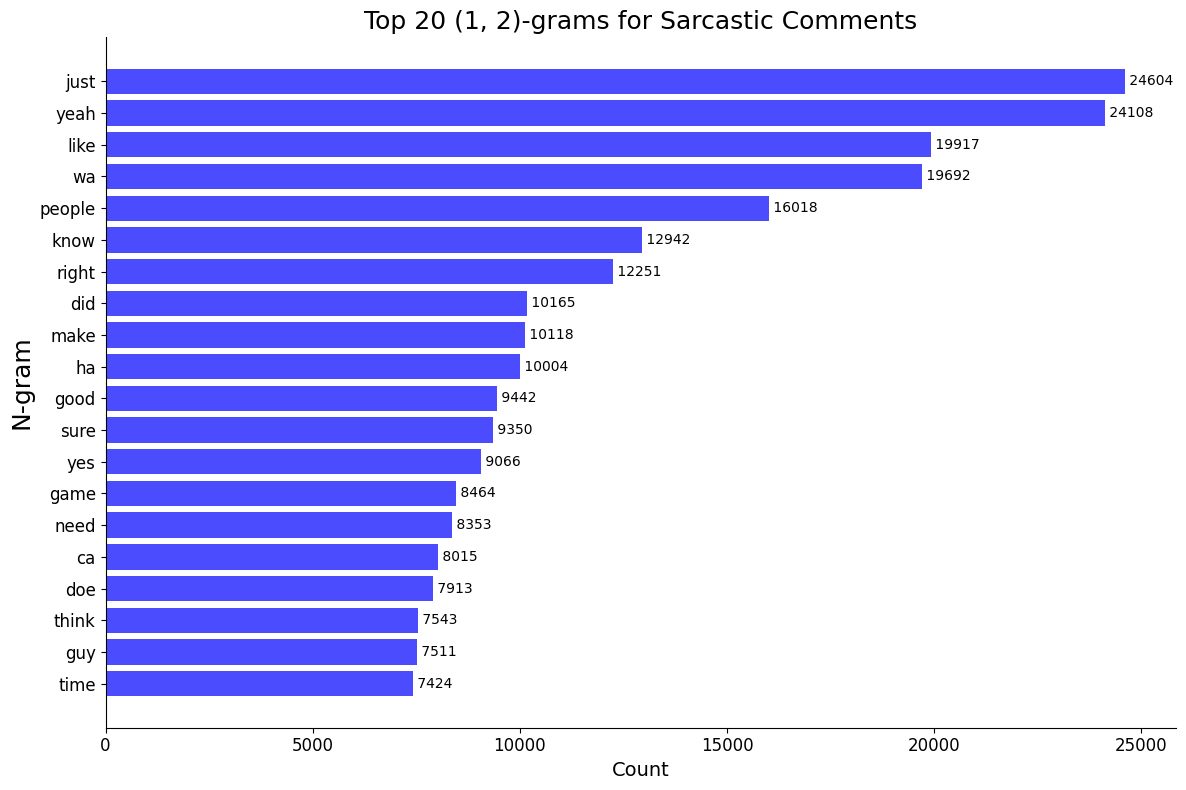

<Figure size 640x480 with 0 Axes>

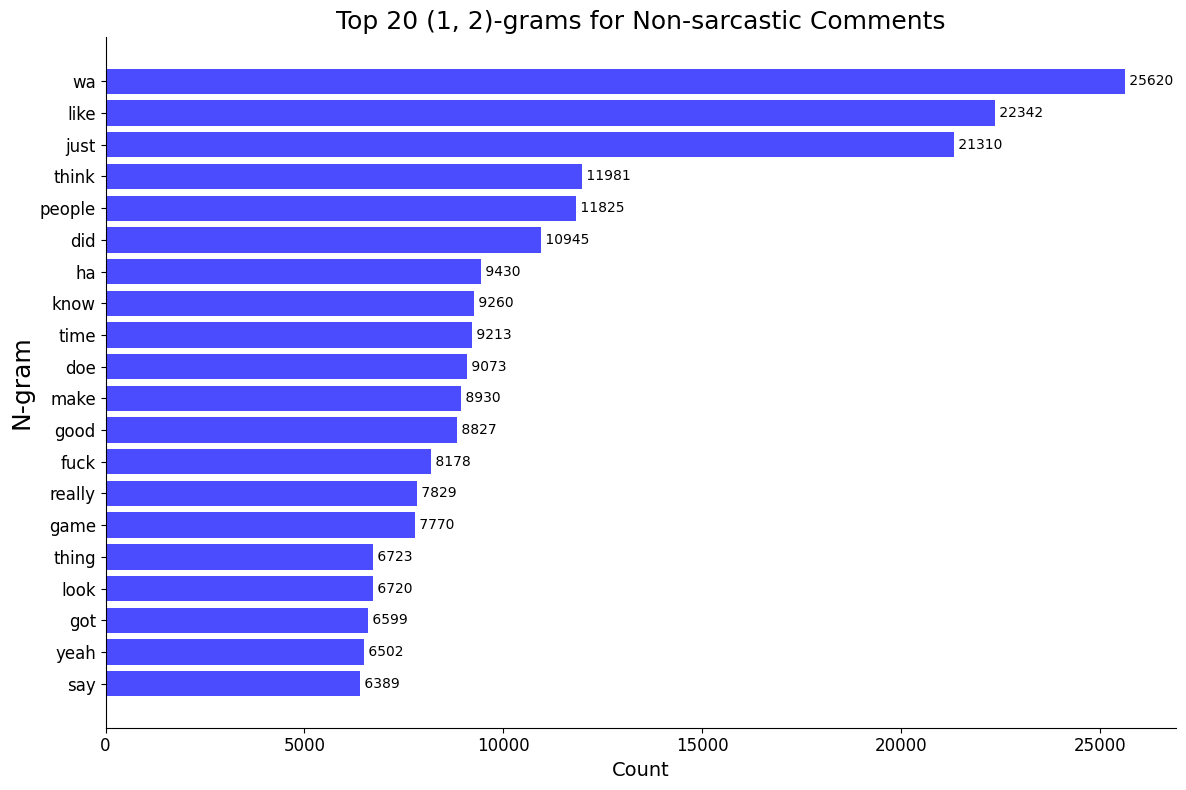

<Figure size 640x480 with 0 Axes>

In [ ]:
def plot_top_grams(df, label_val, n_gram_range = (1, 2), top=20):
  df_label = df[df['label'] == label_val]['comment']
  vectorizer = CountVectorizer(tokenizer=sarcasm_lemma_vectorizer_no_punc, token_pattern=None, lowercase=True, ngram_range=n_gram_range, stop_words='english')
  X = vectorizer.fit_transform(df_label)

  counts = np.asarray(X.sum(axis=0)).flatten()
  vocab = vectorizer.get_feature_names_out()

  freq_df = pd.DataFrame({'ngram': vocab, 'count': counts})
  freq_df = freq_df.sort_values(by='count', ascending=False).head(top)

  plt.figure(figsize=(12, 8))
  bars = plt.barh(freq_df['ngram'], freq_df['count'], color='blue', alpha = 0.7)
  plt.gca().invert_yaxis() # Show highest frequency on top
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('Count', fontsize=14)
  plt.ylabel('N-gram', fontsize=18)
  plt.title(f'Top {top} {n_gram_range}-grams for {'Sarcastic' if label_val == 1 else 'Non-sarcastic'} Comments', fontsize=18)

  # Add data labels
  for bar in bars:
      plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f' {int(bar.get_width())}', va='center')

  plt.tight_layout()
  sns.despine()
  plt.show()
  #plt.savefig(project_path + f'/{'Sarcastic' if label_val == 1 else 'Non-sarcastic'}-BarChart.png')

plot_top_grams(sample_sarcasm, 1)
plot_top_grams(sample_sarcasm, 0)

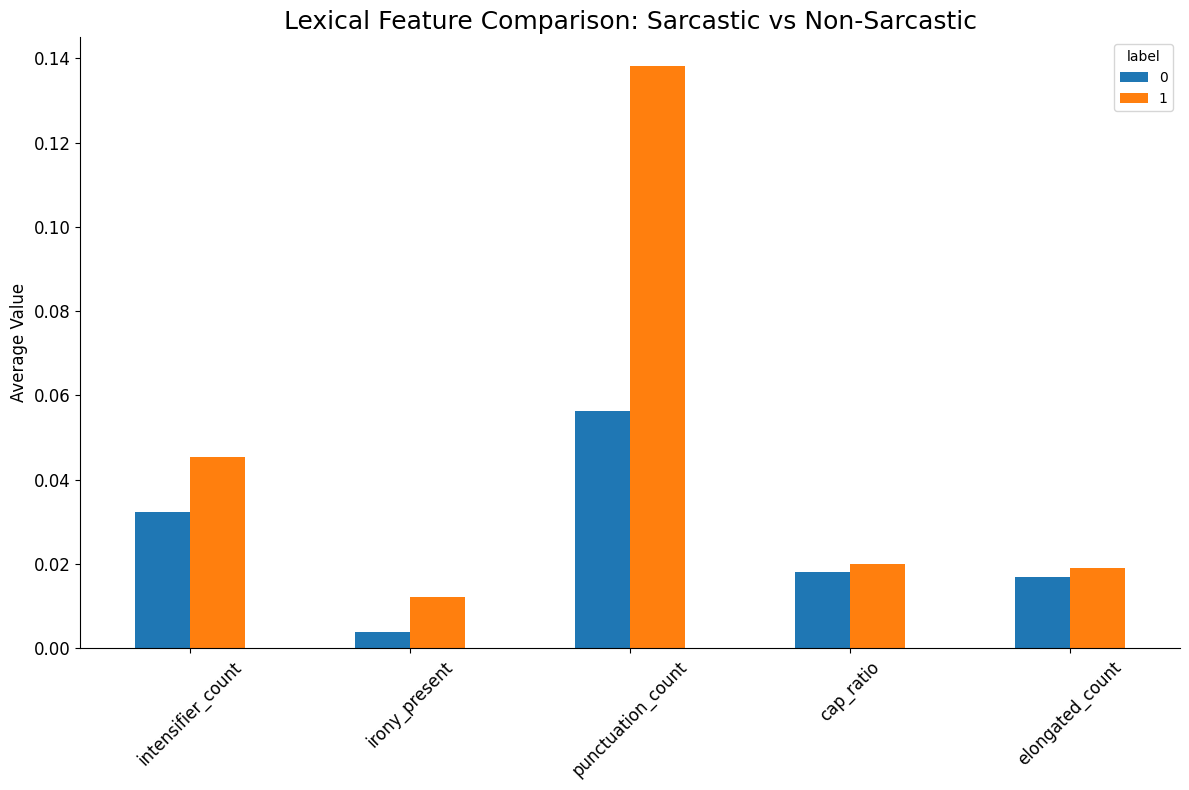

<Figure size 640x480 with 0 Axes>

In [ ]:
# Add lexical features to a df copy for plotting
lexical = build_lexical_matrix(sample_sarcasm['comment'])
lexical_df = sample_sarcasm.copy()

lexical_df[["intensifier_count", "irony_present", "punctuation_count", "cap_ratio", "elongated_count"]] = lexical

feature_cols = [
    "intensifier_count",
    "irony_present",
    "punctuation_count",
    "cap_ratio",
    "elongated_count"
]

grouped = lexical_df.groupby("label")[feature_cols].mean().T

# plot
grouped.plot(kind="bar", figsize=(12,8))
plt.title("Lexical Feature Comparison: Sarcastic vs Non-Sarcastic", fontsize = 18)
plt.ylabel("Average Value", fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
sns.despine()
plt.show()
#plt.savefig(project_path + '/LexicalSarcasmCompareBarChart.png')

There is a trend between the lexical identififers and sarcasm. Most are fairly similar avergae lexical features, expect for punctuation which makes sense. People often need to use punctuation to elicit the inflection they would usually put into voice. Still, the other features have slightly higher usage in sarcastic statments versus non-sarcastic. The word placement and context within the statement also do matter considerably, so this obviously does not tell the whole story.

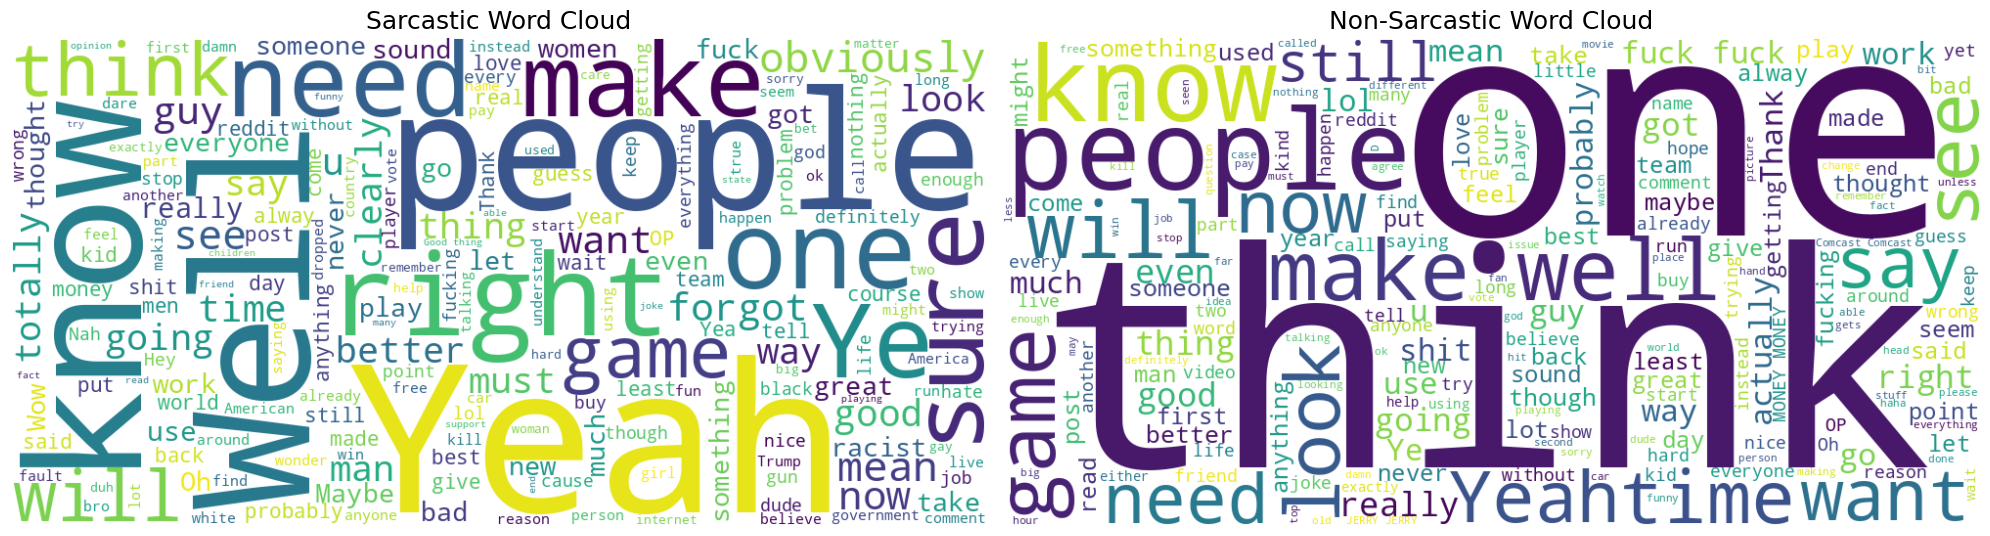

<Figure size 640x480 with 0 Axes>

In [ ]:
# Break out by sarcastic and not sarcastic
sarcastic_text = " ".join(sample_sarcasm[sample_sarcasm["label"] == 1]["comment"].astype(str))
nonsarcastic_text = " ".join(sample_sarcasm[sample_sarcasm["label"] == 0]["comment"].astype(str))

wc_sarc = WordCloud(width=1000, height=500, background_color="white").generate(sarcastic_text)
wc_non  = WordCloud(width=1000, height=500, background_color="white").generate(nonsarcastic_text)

plt.figure(figsize=(20, 12))

plt.subplot(1, 2, 1)
plt.imshow(wc_sarc, interpolation="bilinear")
plt.axis("off")
plt.title("Sarcastic Word Cloud", fontsize=18)

plt.subplot(1, 2, 2)
plt.imshow(wc_non, interpolation="bilinear")
plt.axis("off")
plt.title("Non-Sarcastic Word Cloud", fontsize=18)

plt.tight_layout()

plt.show()
#plt.savefig(project_path + '/wordclouds.png')

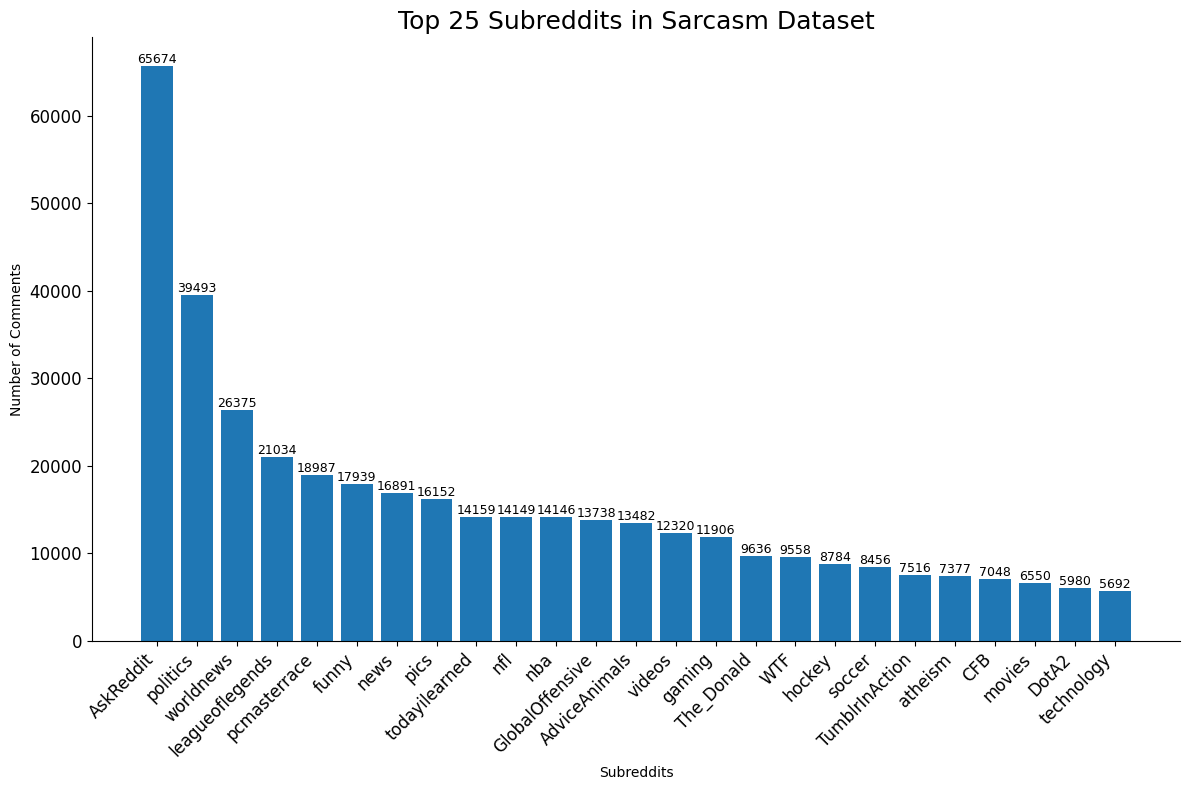

In [ ]:
# Get top 20 subreddits by frequency
top_subreddits = sarcasm['subreddit'].value_counts().head(25)

plt.figure(figsize=(12, 8))
bars = plt.bar(top_subreddits.index, top_subreddits.values)

# Add data labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha='center',
        va='bottom',
        fontsize=9
    )

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Subreddits")
plt.ylabel("Number of Comments")
plt.title("Top 25 Subreddits in Sarcasm Dataset", fontsize = 18)
plt.tight_layout()
sns.despine()
plt.show()

## Baseline TF-IDF

In [ ]:
# Define a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=102, stratify=y)

In [ ]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(tokenizer=sarcasm_lemma_tokenizer, ngram_range=(1, 2), min_df=2, preprocessor=None, token_pattern=None)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
# Add lexical features
X_train_lex = build_lexical_matrix(X_train)
X_test_lex = build_lexical_matrix(X_test)

# Add to dataset
X_train = hstack([X_train_vec, X_train_lex])
X_test = hstack([X_test_vec, X_test_lex])

In [ ]:
# Linear classifier
clf = LogisticRegression(max_iter=500, class_weight = 'balanced')
clf.fit(X_train, y_train)

# Evaluation
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75     75811
           1       0.75      0.71      0.73     75805

    accuracy                           0.74    151616
   macro avg       0.74      0.74      0.74    151616
weighted avg       0.74      0.74      0.74    151616

[[58427 17384]
 [22267 53538]]


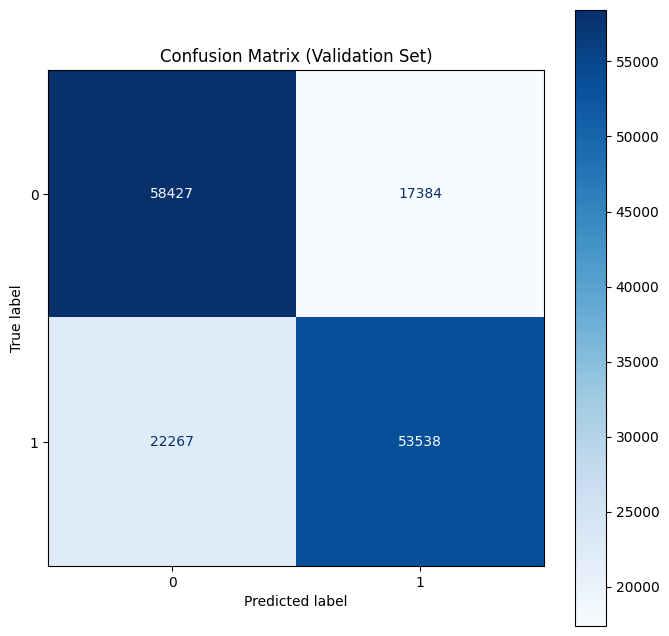

In [5]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

Simple logisitic regression does a nice job on generally learning sarcasm (significantly better than guessing). With a 74% general accuracy (as well as similar statistics across recall, precision, and F1 are all above 70%) this model seems to have a good handle on the task, but it will be more curious to see if the model has began to understand sarcasm or the kind of sarcasm it is seeing on Reddit. Logisitc regression likely will not understand context and setence strucutre as well as RoBERTa, so it will be interesting to do more of a case study on the two of them and see how they perform.

Statistic Interpretation
- General
  - Accuracy: 0.74 - The model predicts sarcasm vs. non-sarcasm correctly about 74% of the time. Fairly accurate for this sort of task!

  - Macro F1: 0.74 - Both classes perform similarly (fairly balanced).

- Sarcastic
  - Precision: 0.75 - When the model predicts sarcastic, it's right 75% of the time.

  - Recall: 0.71 - It only detects 71% of actual sarcastic examples.

  - F1: 0.73

  - The model is more cautious about labeling something as sarcastic (higher precision than recall). This may be due to its lack of ability to understand context and setence structure.

- Not Sarcastic
  -  Precision: 0.72 → When the model predicts non-sarcastic, it is right 72% of the time.

  - Recall: 0.77 → It successfully identifies 77% of the actual non-sarcastic items.

  - F1: 0.75

  - The mode is a bit better at catching non-sarcasm (higher recall than precision).

- The model misses sarcasm mroe than it falsely detects it!

##RoBERTa

In [ ]:
# Utilize GPU well
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True
torch.set_float32_matmul_precision("medium")

/usr/local/lib/python3.12/dist-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float32_matmul_precision(precision)


In [ ]:
# Model defintion with Lexical Features
class RobertaWithLexical(nn.Module):
    def __init__(self, model_name="roberta-base", feature_dim=5, num_labels=2, dropout=0.1):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(model_name)
        hidden_size = self.roberta.config.hidden_size

        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size + feature_dim, num_labels)

    def forward(self, input_ids=None, attention_mask=None, lexical_features=None, labels=None, **kwargs):
        # Roberta embeddings
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)

        cls_emb = outputs.last_hidden_state[:, 0, :]  # CLS token

        # Lexical features
        if lexical_features is None:
            lexical_features = torch.zeros(cls_emb.size(0), 0, device=cls_emb.device, dtype=cls_emb.dtype)
        else:
            lexical_features = lexical_features.to(cls_emb.device)
            if lexical_features.dtype != cls_emb.dtype:
                lexical_features = lexical_features.to(dtype=cls_emb.dtype)

        # Concatenate
        combined = torch.cat([cls_emb, lexical_features], dim=1)
        pooled = self.dropout(combined)
        logits = self.classifier(pooled)

        # Compute loss if labels provided
        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))

        # Return proper HF output
        return SequenceClassifierOutput(loss=loss, logits=logits)

In [ ]:
# Data set up
MODEL_NAME = "roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

X = sample_sarcasm['comment'].tolist()
y = sample_sarcasm['label'].tolist()

def add_lexical(batch):
    batch["lexical_features"] = [np.array(lexical_features_one(x), dtype=np.float32) for x in batch["text"]]
    return batch

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=128)

dataset = Dataset.from_dict({"text": X, "labels": y})
dataset = dataset.train_test_split(test_size=0.2, seed=102)

dataset = dataset.map(add_lexical, batched=True)
dataset = dataset.map(tokenize, batched=True)
dataset = dataset.remove_columns(["text"])
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "lexical_features", "labels"])

We used a train test split here since we are using a lot of data to train. Training loops (even using Colab Pro GPUs) can take 20-30 minutes for one model. Using cross validation would multiply that 5x, which is just too exspensive and time consuming for the resources available.

In [ ]:
# Training helpers

## Freeze - freezes the model weights except the top n
## This allows trianing to not take hours, we can quickly just fine tine
## the top layers of the model and leave the rest of the pretrained model as is.
def freeze_roberta(model, train_last_n=4):
    total = model.roberta.config.num_hidden_layers
    train_from = total - train_last_n

    for name, param in model.roberta.named_parameters():
        match = re.search(r"encoder\.layer\.(\d+)\.", name)
        if match:
            layer = int(match.group(1))
            if layer < train_from:
                param.requires_grad = False
        elif "embeddings" in name:
            param.requires_grad = False

## Training Metrics
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids

    # argmax over classes
    preds = np.argmax(logits, axis=1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="weighted"
    )

    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [ ]:
# Optuna Helpers
def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 6e-5, log=True),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.2),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.0, 0.2)
    }

def model_init(trial=None):
    dropout = 0.1
    train_last_n = 4

    # If Optuna trial is active, override the defaults
    if trial is not None:
        dropout = trial.suggest_float("classifier_dropout", 0.05, 0.4)
        train_last_n = trial.suggest_int("train_last_n", 1, 6)

    model = RobertaWithLexical(dropout=dropout)

    freeze_roberta(model, train_last_n=train_last_n)

    return model

In [ ]:
# Hyperparameter tuning - Ran for over an hour
training_args = TrainingArguments(
    output_dir="optuna_roberta_fast",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    warmup_ratio=0.0,        # overwritten by optuna
    learning_rate=2e-5,      # overwritten by optuna
    weight_decay=0.0,        # overwritten
    eval_strategy="epoch",
    save_strategy="no",
    logging_strategy="no",
    fp16=True,
    optim="adamw_torch_fused",
    report_to="none",
)

trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

study = optuna.create_study(
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=0)
)

best_trial = trainer.hyperparameter_search(
    n_trials=10,                     # fast
    hp_space=optuna_hp_space,
    backend="optuna",
    direction="maximize",
    compute_objective=lambda m: m["eval_f1"],   # F1 target
)

with open("/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/bestHyperParams.json", "w") as f:
    json.dump(best_trial, f)

print(best_trial)
# Output forced to be cut off on commit to github

In [ ]:
# From optuna
with open("/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/bestHyperParams.json", 'r') as f:
        besthyperparameters = json.load(f)

In [ ]:
# View hyperparameters
besthyperparameters

{'learning_rate': 2.485002246616929e-05,
 'weight_decay': 0.1802756018668522,
 'warmup_ratio': 0.018819509939976123,
 'classifier_dropout': 0.16749163342760462,
 'train_last_n': 4}

In [ ]:
# View dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'lexical_features', 'input_ids', 'attention_mask'],
        num_rows: 606462
    })
    test: Dataset({
        features: ['labels', 'lexical_features', 'input_ids', 'attention_mask'],
        num_rows: 151616
    })
})

In [ ]:
# Utilize best parameters
best = besthyperparameters # best_trial.hyperparameters
model = RobertaWithLexical(dropout=best["classifier_dropout"])
freeze_roberta(model, train_last_n=best["train_last_n"])

# Try to compile for speed
try:
    model = torch.compile(model)
    print("Compiled model for faster training.")
except Exception as e:
    print("torch.compile failed:", e)

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    eval_strategy="epoch",
    save_strategy="epoch",
    remove_unused_columns=False,
    fp16=True,
    optim="adamw_torch_fused",
    learning_rate=best["learning_rate"],
    warmup_ratio=best["warmup_ratio"],
    weight_decay=best["weight_decay"],
    num_train_epochs=3,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    dataloader_persistent_workers=True,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
preds_output = trainer.predict(dataset["test"])

logits = preds_output.predictions[1]        # shape: (num_samples, 2)
preds = np.argmax(logits, axis=1)           # predicted classes: 0 or 1
labels = dataset["test"]["labels"]          # Get true labels directly from the dataset

print("Accuracy:", accuracy_score(labels, preds))
print("F1:", f1_score(labels, preds))
print("Confusion matrix:\n", confusion_matrix(labels, preds))
print(classification_report(labels, preds))

Accuracy: 0.7784732482059941
F1: 0.7765588722499783
Confusion matrix:
 [[59664 15777]
 [17810 58365]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     75441
           1       0.79      0.77      0.78     76175

    accuracy                           0.78    151616
   macro avg       0.78      0.78      0.78    151616
weighted avg       0.78      0.78      0.78    151616



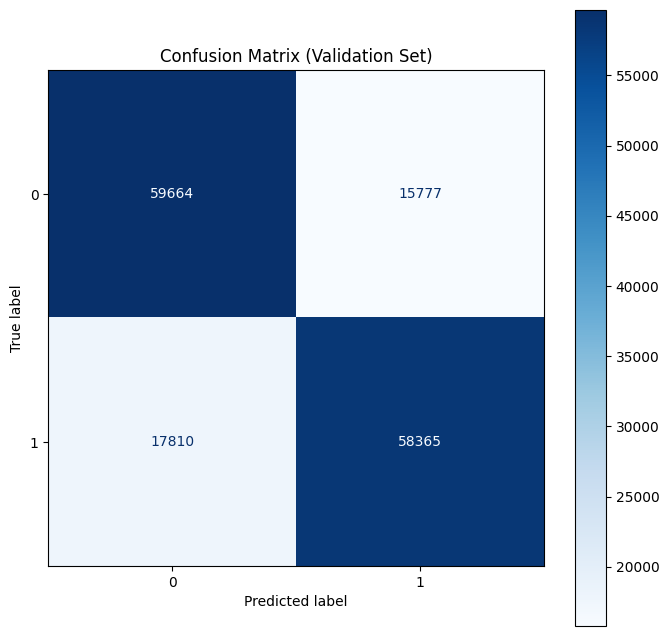

In [9]:
# Plot confusion matrix
cm = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(8, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title("Confusion Matrix (Validation Set)")
plt.show()

The RoBERTa model does a bit better than the TF-IDF model overall. It achieved an accuracy of nearly 78% and an F1 of 78% as well. The model is also more balanced between recall and precision (and higher in both), which helped increase F1. Like the baseline, it is more likely to assume non-sarcastic than sarcastic (higher precision than recall for sarcastic class), but the gap has closed. For a but more perspective, looking at the confusion matrix, RoBERTa missed 4,457 fewer cases than TF-IDF (22,267 - 17,810), which is a significant approvement from baseline! It reduced false sarcasm by 1,607 records (17,384 - 15,777).

Statistic Interpretation

- General
  - Accuracy: 0.778 - Model is correct about predicting sarcasm about 78% of the time.

  - Macro F1: 0.778 - More balanced predictions than baseline. Likely due to RoBERTa capturing subtle lingusitcs that are indicative of sarcasm.

- Sarcasm
  - Precision: 0.79 - When the model predicts sarcastic, it's right 79% of the time.

  - Recall: 0.77 - It correctly identifies 77% of actual sarcastic examples.

  - F1: 0.78 - More balanced than baseline!

  - Sarcasm is still more difficult to predict, but this model is improved in predicting sarcasm considerably (0.71 from baseline to 0.77 for RoBERTa).

- Not Sarcasm
  - Precision: 0.77 - When the model predicts sarcastic, it's right 77% of the time.

  - Recall: 0.79 - It correctly identifies 79% of actual sarcastic examples.

  - F1: 0.78 - More balanced than baseline

In [ ]:
def predict_sarcasm(model, text, tokenizer=tokenizer, device=None):
    model.eval()
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    if isinstance(text, str):
        texts = [text]
    else:
        texts = text

    # Tokenize
    encodings = tokenizer(texts, truncation=True, padding="max_length", max_length=128, return_tensors="pt")

    # Lexical features
    lexical_features = torch.tensor([lexical_features_one(t) for t in texts], dtype=torch.float32)

    # Move to device
    input_ids = encodings["input_ids"].to(device)
    attention_mask = encodings["attention_mask"].to(device)
    lexical_features = lexical_features.to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        lexical_features=lexical_features)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        preds = np.argmax(probs, axis=1)

    # Return single prediction if input was a string
    if isinstance(text, str):
        return {"predicted_label": int(preds[0]), "probabilities": probs[0]}
    else:
        return [{"predicted_label": int(p), "probabilities": prob} for p, prob in zip(preds, probs)]

statement = "Thank you for taking your sweet time on this!"

result = predict_sarcasm(model, statement)
print("Predicted label:", result["predicted_label"])  # 0 = not sarcastic, 1 = sarcastic
print("Probabilities:", result["probabilities"])

Predicted label: 0
Probabilities: [0.8580062  0.14199378]


In [ ]:
statements = [
    # Obvious sarcasm
    "Oh great, another Monday morning… just what I needed!",
    "I absolutely love it when my phone dies in the middle of an important call.",
    "Sure, I’d love to do more paperwork instead of going home early.",
    "Yeah right, because traffic is exactly what I was hoping for today.",
    "I totally enjoy waking up to the sound of my neighbor’s dog at 5 AM.",

    # Mild sarcasm
    "Wow, that movie was really… interesting.",
    "I’m so glad it’s raining again, just perfect for a picnic.",
    "Oh sure, because staying late at work is my favorite hobby.",

    # Neutral / serious
    "I had a sandwich for lunch.",
    "The sky is blue today.",
    "I am going to the grocery store after work.",
    "She won the award for best performance."
]

statement_results = []
results = predict_sarcasm(model, statements)
for r, s in zip(results, statements):
    statement_results.append({'Statement' : s, 'Is_Sarcastic' : r['predicted_label'] == 1})
display(pd.DataFrame(statement_results))

W1207 01:40:18.212000 4889 torch/fx/experimental/symbolic_shapes.py:6833] [0/4] _maybe_guard_rel() was called on non-relation expression Eq(s43, 1) | Eq(s72, s43)


,Statement,Is_Sarcastic
0,"Oh great, another Monday morning… just what I ...",True
1,I absolutely love it when my phone dies in the...,True
2,"Sure, I’d love to do more paperwork instead of...",False
3,"Yeah right, because traffic is exactly what I ...",True
4,I totally enjoy waking up to the sound of my n...,True
5,"Wow, that movie was really… interesting.",False
6,"I’m so glad it’s raining again, just perfect f...",True
7,"Oh sure, because staying late at work is my fa...",True
8,I had a sandwich for lunch.,False
9,The sky is blue today.,False


In [ ]:
statements_tfidf_vec = vectorizer.transform(statements)
statements_lex_features = build_lexical_matrix(statements)

statements_combined_features = hstack([statements_tfidf_vec, statements_lex_features])

tfidf_predictions = clf.predict(statements_combined_features)

# Create a DataFrame to display the results
tfidf_results = []
for s, pred in zip(statements, tfidf_predictions):
    tfidf_results.append({'Statement': s, 'Is_Sarcastic': bool(pred)})

display(pd.DataFrame(tfidf_results))

,Statement,Is_Sarcastic
0,"Oh great, another Monday morning… just what I ...",True
1,I absolutely love it when my phone dies in the...,False
2,"Sure, I’d love to do more paperwork instead of...",True
3,"Yeah right, because traffic is exactly what I ...",True
4,I totally enjoy waking up to the sound of my n...,False
5,"Wow, that movie was really… interesting.",False
6,"I’m so glad it’s raining again, just perfect f...",False
7,"Oh sure, because staying late at work is my fa...",True
8,I had a sandwich for lunch.,False
9,The sky is blue today.,False


This is a pop quiz sort of test where I decided to write some statements in which I believed some were sarcsastic and some were not (not from dataset). The first 8 were meant to be sarcastic and the last 4 not sarcastic. I found it very interesting that `RoBERTa` only got 2 wrong while while `TF-IDF` got 5 wrong. To me, it seems that the TF-IDF did its assignment and learned sarcasm from the dataset, but RoBERTa actually learned the essence of sarcasm, making it generalize better to statements outside the dataset. Reddit has its own kind of biases where people post comments or use phrases in a way that does not come up in daily conversation or texting with friends. In short, it seems TF-IDF learned how people use sarcasm on Reddit, while RoBERTa was able to learn from Reddit how people generally utilize sarcasm.

In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/roberta_lexical_weights.pt")

config = {
    'model_name' : "roberta-base",
    'feature_dim' : 5,
    'num_labels' : 2
}

with open("/content/drive/MyDrive/Final AIML Project - Sarcasm Detection/HypertunedRoBerta/config.json", "w") as f:
    json.dump(config, f)